In [145]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./src')

from chatgpt_util_imports import generate_dataset
from data_loader import PatchDataset
from models import VAE, AE
from train import collect_embeddings, load_checkpoint, print_loss_metrics, save_checkpoint, train_one_epoch, validate
from util import get_date_and_time

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [147]:
# Load +31k patches as compiled by `bwhitman` for `learnfm`.
fpath = 'data/compact.bin'

df = generate_dataset(fpath)
df = pd.DataFrame(df)

print(f"Num patches: {len(df)}")
print(f"Num features: {len(df.keys())}")

Num patches: 31380
Num features: 146


In [148]:
p_train = 0.8
batch_size = 128

dataset = PatchDataset(df)

n_train = int(p_train * len(dataset))
n_val = len(dataset) - n_train

train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [149]:
dimensions = [128, 64, 32]
model_type = 'ae'

n_features = len(dataset._parameter_names)
n_latent = dimensions[-1]

if model_type == 'ae':
    model = AE(n_features, *dimensions)
elif model_type == 'vae':
    model = VAE(n_features, *dimensions)

model = model.to(device)

Epoch 0
Trn: 0.00581012	Val: 0.00474389



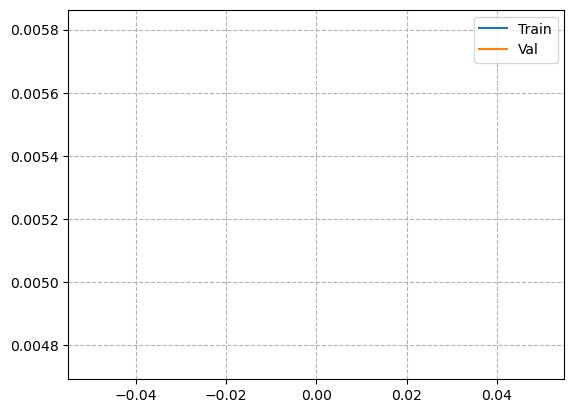

Saved checkpoint at: checkpoints/chkpnt_20231018_092228_epoch0.pt
Epoch 1
Trn: 0.00430965	Val: 0.00409538

Epoch 2
Trn: 0.00384841	Val: 0.00376887

Epoch 3
Trn: 0.00357586	Val: 0.00354469

Epoch 4
Trn: 0.00338417	Val: 0.00339233

Epoch 5
Trn: 0.00324735	Val: 0.00326223

Epoch 6
Trn: 0.00313589	Val: 0.00317918

Epoch 7
Trn: 0.00304870	Val: 0.00310129

Epoch 8
Trn: 0.00297568	Val: 0.00302355

Epoch 9
Trn: 0.00292077	Val: 0.00298656

Epoch 10
Trn: 0.00287083	Val: 0.00293163

Saved checkpoint at: checkpoints/chkpnt_20231018_092242_epoch10.pt
Epoch 11
Trn: 0.00283094	Val: 0.00290549

Epoch 12
Trn: 0.00279446	Val: 0.00287649

Epoch 13
Trn: 0.00276719	Val: 0.00284797

Epoch 14
Trn: 0.00274343	Val: 0.00281866

Epoch 15
Trn: 0.00271984	Val: 0.00280692

Epoch 16
Trn: 0.00269176	Val: 0.00278261

Epoch 17
Trn: 0.00267073	Val: 0.00274347

Epoch 18
Trn: 0.00264434	Val: 0.00273670

Epoch 19
Trn: 0.00262573	Val: 0.00272256

Epoch 20
Trn: 0.00260754	Val: 0.00270916

Saved checkpoint at: checkpoints/chk

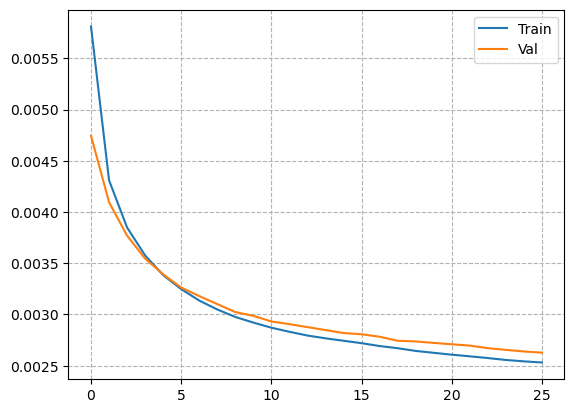

Epoch 26
Trn: 0.00251571	Val: 0.00261811

Epoch 27
Trn: 0.00250607	Val: 0.00260708

Epoch 28
Trn: 0.00249261	Val: 0.00259310

Epoch 29
Trn: 0.00248175	Val: 0.00258897

Epoch 30
Trn: 0.00246709	Val: 0.00256971

Saved checkpoint at: checkpoints/chkpnt_20231018_092311_epoch30.pt
Epoch 31
Trn: 0.00245781	Val: 0.00256508

Epoch 32
Trn: 0.00245115	Val: 0.00256729

Epoch 33
Trn: 0.00244051	Val: 0.00254448

Epoch 34
Trn: 0.00242730	Val: 0.00254716

Epoch 35
Trn: 0.00241933	Val: 0.00253279

Epoch 36
Trn: 0.00241086	Val: 0.00252600

Epoch 37
Trn: 0.00240089	Val: 0.00251074

Epoch 38
Trn: 0.00239168	Val: 0.00250350

Epoch 39
Trn: 0.00238678	Val: 0.00251275

Epoch 40
Trn: 0.00238031	Val: 0.00249479

Saved checkpoint at: checkpoints/chkpnt_20231018_092325_epoch40.pt
Epoch 41
Trn: 0.00237056	Val: 0.00248016

Epoch 42
Trn: 0.00236062	Val: 0.00246188

Epoch 43
Trn: 0.00235695	Val: 0.00246037

Epoch 44
Trn: 0.00234637	Val: 0.00246583

Epoch 45
Trn: 0.00233760	Val: 0.00245452

Epoch 46
Trn: 0.00233604	V

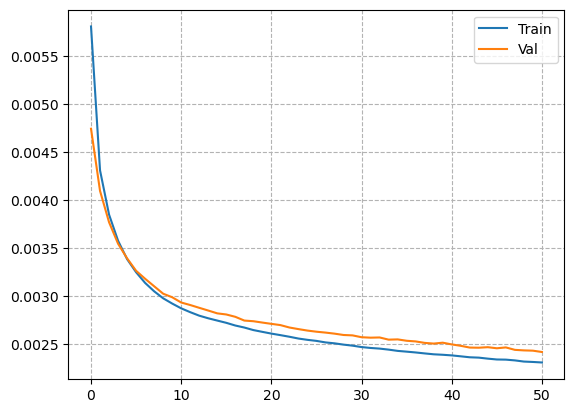

Saved checkpoint at: checkpoints/chkpnt_20231018_092339_epoch50.pt
Epoch 51
Trn: 0.00229911	Val: 0.00241711

Epoch 52
Trn: 0.00229929	Val: 0.00241395

Epoch 53
Trn: 0.00228838	Val: 0.00241858

Epoch 54
Trn: 0.00228341	Val: 0.00240007

Epoch 55
Trn: 0.00227994	Val: 0.00242060

Epoch 56
Trn: 0.00227217	Val: 0.00239207

Epoch 57
Trn: 0.00227240	Val: 0.00239176

Epoch 58
Trn: 0.00226476	Val: 0.00239009

Epoch 59
Trn: 0.00225987	Val: 0.00239581

Epoch 60
Trn: 0.00225802	Val: 0.00239543

Saved checkpoint at: checkpoints/chkpnt_20231018_092353_epoch60.pt
Epoch 61
Trn: 0.00225413	Val: 0.00237583

Epoch 62
Trn: 0.00224940	Val: 0.00237340

Epoch 63
Trn: 0.00224200	Val: 0.00235883

Epoch 64
Trn: 0.00223486	Val: 0.00236145

Epoch 65
Trn: 0.00223307	Val: 0.00236311

Epoch 66
Trn: 0.00223120	Val: 0.00235814

Epoch 67
Trn: 0.00222336	Val: 0.00235235

Epoch 68
Trn: 0.00221817	Val: 0.00236129

Epoch 69
Trn: 0.00221705	Val: 0.00233144

Epoch 70
Trn: 0.00221762	Val: 0.00234457

Saved checkpoint at: check

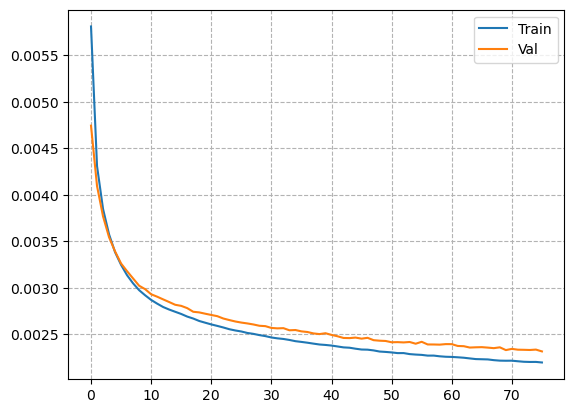

Epoch 76
Trn: 0.00219617	Val: 0.00231337

Epoch 77
Trn: 0.00219126	Val: 0.00233203

Epoch 78
Trn: 0.00218599	Val: 0.00231202

Epoch 79
Trn: 0.00218261	Val: 0.00230744

Epoch 80
Trn: 0.00218647	Val: 0.00235393

Epoch 81
Trn: 0.00218614	Val: 0.00231261

Epoch 82
Trn: 0.00217448	Val: 0.00229560

Epoch 83
Trn: 0.00217207	Val: 0.00230201

Epoch 84
Trn: 0.00216945	Val: 0.00228452

Epoch 85
Trn: 0.00216586	Val: 0.00229221

Epoch 86
Trn: 0.00216380	Val: 0.00229077

Epoch 87
Trn: 0.00215905	Val: 0.00227663

Epoch 88
Trn: 0.00215861	Val: 0.00228694

Epoch 89
Trn: 0.00215790	Val: 0.00229862

Epoch 90
Trn: 0.00215556	Val: 0.00227264

Saved checkpoint at: checkpoints/chkpnt_20231018_092439_epoch90.pt
Epoch 91
Trn: 0.00215050	Val: 0.00226877

Epoch 92
Trn: 0.00214938	Val: 0.00228335

Epoch 93
Trn: 0.00214795	Val: 0.00227721

Epoch 94
Trn: 0.00214715	Val: 0.00228513

Epoch 95
Trn: 0.00214141	Val: 0.00227192

Epoch 96
Trn: 0.00214104	Val: 0.00226628

Epoch 97
Trn: 0.00214477	Val: 0.00226345

Epoch 98


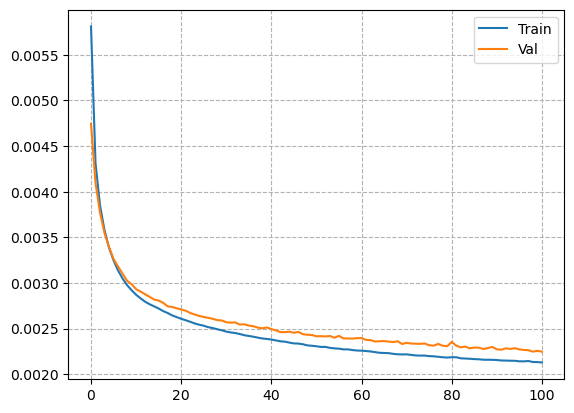

Saved checkpoint at: checkpoints/chkpnt_20231018_092454_epoch100.pt
Epoch 101
Trn: 0.00213104	Val: 0.00226044

Epoch 102
Trn: 0.00212921	Val: 0.00225549

Epoch 103
Trn: 0.00212456	Val: 0.00224820

Epoch 104
Trn: 0.00212402	Val: 0.00222990

Epoch 105
Trn: 0.00212171	Val: 0.00224864

Epoch 106
Trn: 0.00211691	Val: 0.00224695

Epoch 107
Trn: 0.00211722	Val: 0.00224098

Epoch 108
Trn: 0.00211538	Val: 0.00224422

Epoch 109
Trn: 0.00211526	Val: 0.00225306

Epoch 110
Trn: 0.00211520	Val: 0.00225463

Epoch 111
Trn: 0.00211338	Val: 0.00227604

Epoch 112
Trn: 0.00210798	Val: 0.00222661

Epoch 113
Trn: 0.00210722	Val: 0.00223320

Epoch 114
Trn: 0.00210568	Val: 0.00223762

Epoch 115
Trn: 0.00210355	Val: 0.00222648

Epoch 116
Trn: 0.00210214	Val: 0.00225321

Epoch 117
Trn: 0.00210405	Val: 0.00222749

Epoch 118
Trn: 0.00209823	Val: 0.00222811

Epoch 119
Trn: 0.00209848	Val: 0.00224803

Epoch 120
Trn: 0.00209574	Val: 0.00222572

Saved checkpoint at: checkpoints/chkpnt_20231018_092523_epoch120.pt
Epoc

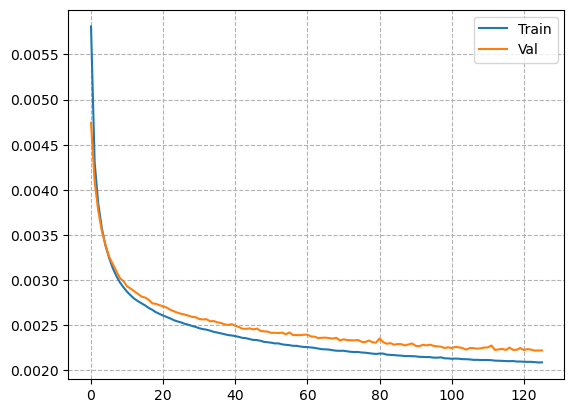

Epoch 126
Trn: 0.00208942	Val: 0.00221701

Epoch 127
Trn: 0.00208464	Val: 0.00221467

Epoch 128
Trn: 0.00208412	Val: 0.00221799

Epoch 129
Trn: 0.00208450	Val: 0.00221628

Epoch 130
Trn: 0.00208273	Val: 0.00220149

Saved checkpoint at: checkpoints/chkpnt_20231018_092538_epoch130.pt
Epoch 131
Trn: 0.00208271	Val: 0.00221905

Epoch 132
Trn: 0.00208364	Val: 0.00222058

Epoch 133
Trn: 0.00208076	Val: 0.00223034

Epoch 134
Trn: 0.00207933	Val: 0.00221719

Epoch 135
Trn: 0.00207727	Val: 0.00223476

Epoch 136
Trn: 0.00207638	Val: 0.00221425

Epoch 137
Trn: 0.00207348	Val: 0.00222309

Epoch 138
Trn: 0.00207290	Val: 0.00220141

Epoch 139
Trn: 0.00207501	Val: 0.00220684

Epoch 140
Trn: 0.00206923	Val: 0.00220853

Epoch 00142: reducing learning rate of group 0 to 1.0000e-04.
Epoch 141
Trn: 0.00207144	Val: 0.00220566

Epoch 142
Trn: 0.00201050	Val: 0.00213380

Epoch 143
Trn: 0.00200249	Val: 0.00213120

Epoch 144
Trn: 0.00200083	Val: 0.00213087

Epoch 145
Trn: 0.00200358	Val: 0.00213026

Epoch 146


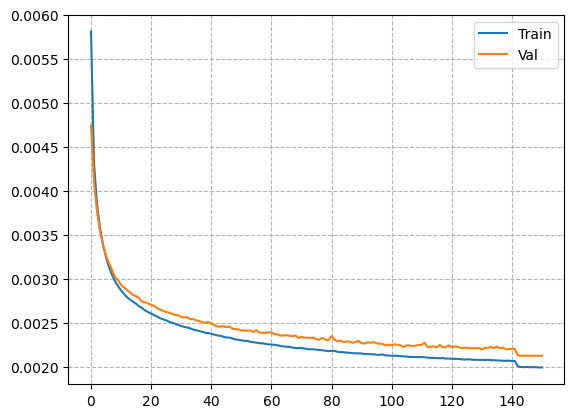

Saved checkpoint at: checkpoints/chkpnt_20231018_092608_epoch150.pt
Epoch 151
Trn: 0.00199912	Val: 0.00212837

Epoch 152
Trn: 0.00200123	Val: 0.00212954

Epoch 153
Trn: 0.00200108	Val: 0.00213010

Epoch 154
Trn: 0.00199666	Val: 0.00212918

Epoch 155
Trn: 0.00199801	Val: 0.00212983

Epoch 156
Trn: 0.00199715	Val: 0.00212844

Epoch 157
Trn: 0.00199691	Val: 0.00212877

Epoch 158
Trn: 0.00199639	Val: 0.00212966

Epoch 159
Trn: 0.00199372	Val: 0.00212762

Epoch 160
Trn: 0.00199373	Val: 0.00212874

Saved checkpoint at: checkpoints/chkpnt_20231018_092622_epoch160.pt
Epoch 161
Trn: 0.00199377	Val: 0.00212739

Epoch 162
Trn: 0.00199402	Val: 0.00212742

Epoch 163
Trn: 0.00199331	Val: 0.00212690

Epoch 164
Trn: 0.00199459	Val: 0.00212764

Epoch 165
Trn: 0.00199312	Val: 0.00212640

Epoch 166
Trn: 0.00199202	Val: 0.00212669

Epoch 167
Trn: 0.00199235	Val: 0.00212793

Epoch 168
Trn: 0.00199313	Val: 0.00212612

Epoch 169
Trn: 0.00199379	Val: 0.00212558

Epoch 170
Trn: 0.00199722	Val: 0.00212746

Save

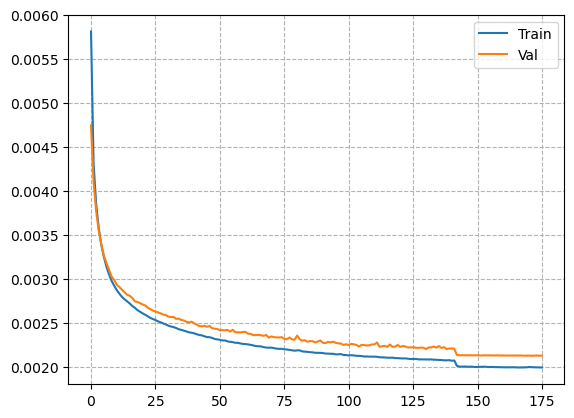

Epoch 176
Trn: 0.00199666	Val: 0.00212847

Epoch 177
Trn: 0.00199068	Val: 0.00212445

Epoch 178
Trn: 0.00199171	Val: 0.00212576

Epoch 179
Trn: 0.00199195	Val: 0.00212652

Epoch 180
Trn: 0.00199224	Val: 0.00212528

Saved checkpoint at: checkpoints/chkpnt_20231018_092652_epoch180.pt
Epoch 181
Trn: 0.00198967	Val: 0.00212734

Epoch 182
Trn: 0.00199463	Val: 0.00212545

Epoch 183
Trn: 0.00198889	Val: 0.00212308

Epoch 184
Trn: 0.00199055	Val: 0.00212547

Epoch 185
Trn: 0.00199114	Val: 0.00212425

Epoch 186
Trn: 0.00198944	Val: 0.00212587

Epoch 187
Trn: 0.00198686	Val: 0.00212399

Epoch 188
Trn: 0.00198689	Val: 0.00212261

Epoch 189
Trn: 0.00199132	Val: 0.00212357

Epoch 190
Trn: 0.00198956	Val: 0.00212318

Saved checkpoint at: checkpoints/chkpnt_20231018_092706_epoch190.pt
Epoch 191
Trn: 0.00198724	Val: 0.00212297

Epoch 192
Trn: 0.00198663	Val: 0.00212307

Epoch 193
Trn: 0.00198861	Val: 0.00212278

Epoch 194
Trn: 0.00198907	Val: 0.00212400

Epoch 195
Trn: 0.00198614	Val: 0.00212237

Epoc

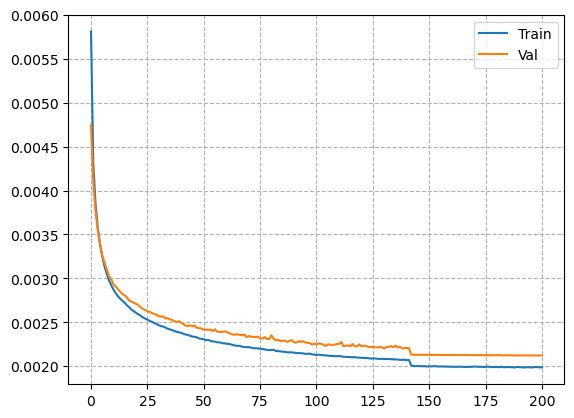

Epoch 201
Trn: 0.00198686	Val: 0.00212201

Epoch 202
Trn: 0.00198572	Val: 0.00212075

Epoch 203
Trn: 0.00198509	Val: 0.00212167

Epoch 204
Trn: 0.00198433	Val: 0.00212151

Epoch 205
Trn: 0.00198763	Val: 0.00212212

Epoch 206
Trn: 0.00198413	Val: 0.00212092

Epoch 207
Trn: 0.00198437	Val: 0.00212332

Epoch 208
Trn: 0.00198245	Val: 0.00212170

Epoch 209
Trn: 0.00198414	Val: 0.00212076

Epoch 210
Trn: 0.00198240	Val: 0.00211990

Saved checkpoint at: checkpoints/chkpnt_20231018_092736_epoch210.pt
Epoch 211
Trn: 0.00198411	Val: 0.00212004

Epoch 212
Trn: 0.00198377	Val: 0.00211986

Epoch 213
Trn: 0.00198311	Val: 0.00212048

Epoch 214
Trn: 0.00198168	Val: 0.00212004

Epoch 215
Trn: 0.00198269	Val: 0.00211982

Epoch 216
Trn: 0.00198353	Val: 0.00212033

Epoch 217
Trn: 0.00198117	Val: 0.00211832

Epoch 218
Trn: 0.00198533	Val: 0.00212011

Epoch 219
Trn: 0.00198280	Val: 0.00212052

Epoch 220
Trn: 0.00198389	Val: 0.00211903

Saved checkpoint at: checkpoints/chkpnt_20231018_092750_epoch220.pt
Epoc

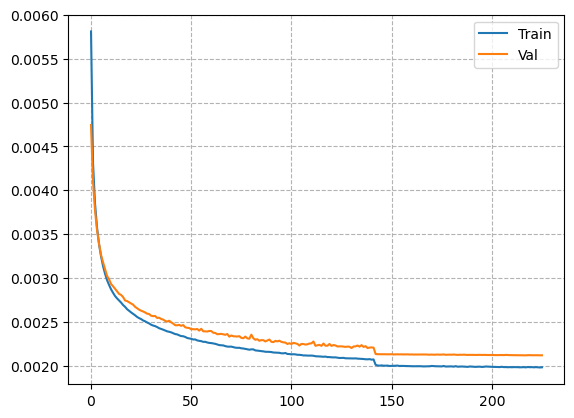

Epoch 226
Trn: 0.00198119	Val: 0.00211701

Epoch 227
Trn: 0.00198238	Val: 0.00211847

Epoch 228
Trn: 0.00197946	Val: 0.00211844

Epoch 229
Trn: 0.00197984	Val: 0.00211779

Epoch 230
Trn: 0.00198118	Val: 0.00211791

Saved checkpoint at: checkpoints/chkpnt_20231018_092805_epoch230.pt
Epoch 231
Trn: 0.00198086	Val: 0.00211795

Epoch 232
Trn: 0.00198054	Val: 0.00211654

Epoch 233
Trn: 0.00198184	Val: 0.00211706

Epoch 234
Trn: 0.00197998	Val: 0.00211864

Epoch 235
Trn: 0.00197832	Val: 0.00211714

Epoch 236
Trn: 0.00197863	Val: 0.00211736

Epoch 237
Trn: 0.00197948	Val: 0.00211565

Epoch 238
Trn: 0.00197628	Val: 0.00211755

Epoch 239
Trn: 0.00197999	Val: 0.00211740

Epoch 240
Trn: 0.00197703	Val: 0.00211808

Epoch 241
Trn: 0.00197934	Val: 0.00211733

Epoch 242
Trn: 0.00197728	Val: 0.00211769

Epoch 243
Trn: 0.00198112	Val: 0.00211511

Epoch 244
Trn: 0.00198062	Val: 0.00211639

Epoch 245
Trn: 0.00197850	Val: 0.00211706

Epoch 246
Trn: 0.00197772	Val: 0.00211643

Epoch 247
Trn: 0.00198416	Val

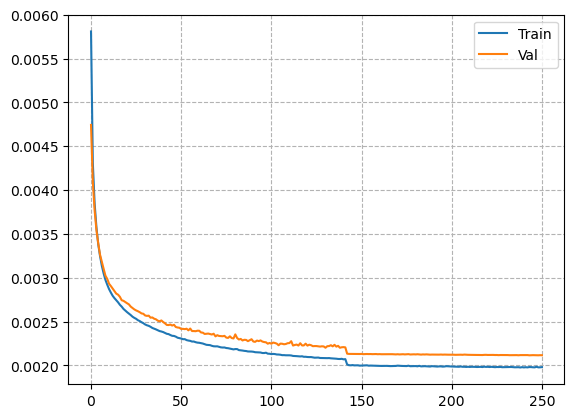

Saved checkpoint at: checkpoints/chkpnt_20231018_092834_epoch250.pt
Epoch 251
Trn: 0.00197633	Val: 0.00211504

Epoch 252
Trn: 0.00197878	Val: 0.00211400

Epoch 253
Trn: 0.00197706	Val: 0.00211481

Epoch 254
Trn: 0.00198020	Val: 0.00211315

Epoch 255
Trn: 0.00197808	Val: 0.00211452

Epoch 256
Trn: 0.00197980	Val: 0.00211364

Epoch 257
Trn: 0.00198311	Val: 0.00211635

Epoch 258
Trn: 0.00197686	Val: 0.00211384

Epoch 259
Trn: 0.00197873	Val: 0.00211363

Epoch 260
Trn: 0.00197787	Val: 0.00211407

Saved checkpoint at: checkpoints/chkpnt_20231018_092848_epoch260.pt
Epoch 261
Trn: 0.00197551	Val: 0.00211568

Epoch 262
Trn: 0.00197569	Val: 0.00211298

Epoch 263
Trn: 0.00197485	Val: 0.00211263

Epoch 264
Trn: 0.00197687	Val: 0.00211466

Epoch 265
Trn: 0.00197628	Val: 0.00211273

Epoch 266
Trn: 0.00197809	Val: 0.00211340

Epoch 267
Trn: 0.00197223	Val: 0.00211200

Epoch 268
Trn: 0.00197471	Val: 0.00211543

Epoch 269
Trn: 0.00197241	Val: 0.00211257

Epoch 270
Trn: 0.00197284	Val: 0.00211400

Save

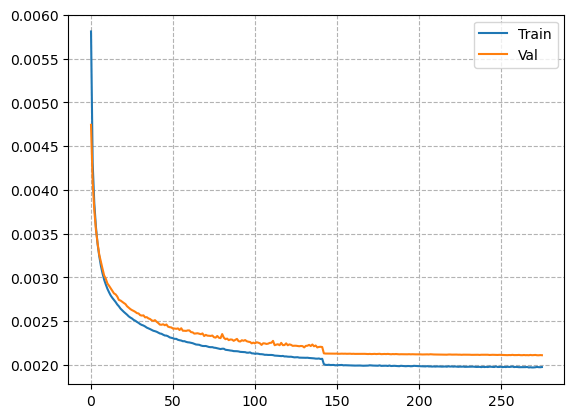

Epoch 276
Trn: 0.00197302	Val: 0.00211281

Epoch 277
Trn: 0.00197299	Val: 0.00211332

Epoch 278
Trn: 0.00197436	Val: 0.00211284

Epoch 279
Trn: 0.00197318	Val: 0.00211249

Epoch 280
Trn: 0.00197425	Val: 0.00210992

Saved checkpoint at: checkpoints/chkpnt_20231018_092916_epoch280.pt
Epoch 281
Trn: 0.00197261	Val: 0.00211209

Epoch 282
Trn: 0.00197466	Val: 0.00211194

Epoch 283
Trn: 0.00197748	Val: 0.00211080

Epoch 284
Trn: 0.00197538	Val: 0.00211306

Epoch 285
Trn: 0.00197027	Val: 0.00211094

Epoch 286
Trn: 0.00196997	Val: 0.00211143

Epoch 287
Trn: 0.00197207	Val: 0.00210905

Epoch 288
Trn: 0.00197218	Val: 0.00211053

Epoch 289
Trn: 0.00197373	Val: 0.00211014

Epoch 290
Trn: 0.00197341	Val: 0.00211262

Epoch 291
Trn: 0.00197056	Val: 0.00210856

Epoch 292
Trn: 0.00197215	Val: 0.00211049

Epoch 293
Trn: 0.00197390	Val: 0.00211034

Epoch 294
Trn: 0.00196959	Val: 0.00210952

Epoch 295
Trn: 0.00197348	Val: 0.00211025

Epoch 296
Trn: 0.00197230	Val: 0.00210966

Epoch 297
Trn: 0.00197234	Val

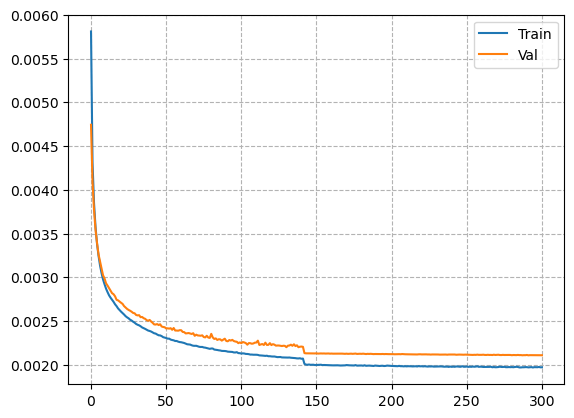

Saved checkpoint at: checkpoints/chkpnt_20231018_092944_epoch300.pt
Epoch 301
Trn: 0.00197194	Val: 0.00210989

Epoch 302
Trn: 0.00196908	Val: 0.00210782

Epoch 303
Trn: 0.00196781	Val: 0.00211007

Epoch 304
Trn: 0.00196971	Val: 0.00211019

Epoch 305
Trn: 0.00196979	Val: 0.00210886

Epoch 306
Trn: 0.00196792	Val: 0.00211110

Epoch 307
Trn: 0.00196953	Val: 0.00210904

Epoch 308
Trn: 0.00196805	Val: 0.00210890

Epoch 309
Trn: 0.00197002	Val: 0.00210967

Epoch 310
Trn: 0.00197383	Val: 0.00210895

Saved checkpoint at: checkpoints/chkpnt_20231018_092959_epoch310.pt
Epoch 311
Trn: 0.00196886	Val: 0.00210542

Epoch 312
Trn: 0.00197041	Val: 0.00210696

Epoch 313
Trn: 0.00196808	Val: 0.00210690

Epoch 314
Trn: 0.00196913	Val: 0.00210806

Epoch 315
Trn: 0.00197225	Val: 0.00210757

Epoch 316
Trn: 0.00196739	Val: 0.00210856

Epoch 317
Trn: 0.00196900	Val: 0.00210697

Epoch 318
Trn: 0.00197072	Val: 0.00210838

Epoch 319
Trn: 0.00197047	Val: 0.00210916

Epoch 320
Trn: 0.00196767	Val: 0.00210676

Save

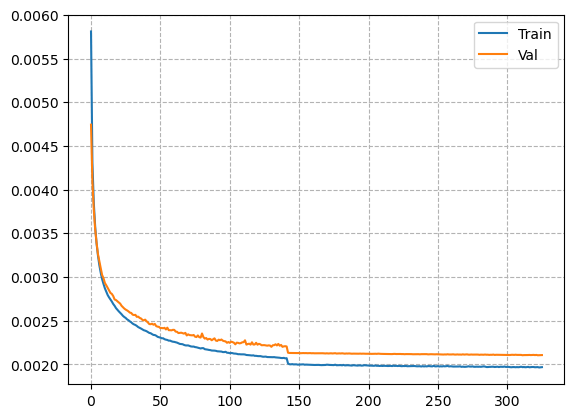

Epoch 326
Trn: 0.00196646	Val: 0.00210632

Epoch 327
Trn: 0.00196541	Val: 0.00210801

Epoch 328
Trn: 0.00196681	Val: 0.00210662

Epoch 329
Trn: 0.00196542	Val: 0.00210482

Epoch 330
Trn: 0.00196577	Val: 0.00210425

Saved checkpoint at: checkpoints/chkpnt_20231018_093027_epoch330.pt
Epoch 331
Trn: 0.00196583	Val: 0.00210749

Epoch 332
Trn: 0.00196559	Val: 0.00210549

Epoch 333
Trn: 0.00196504	Val: 0.00210517

Epoch 334
Trn: 0.00196671	Val: 0.00210472

Epoch 335
Trn: 0.00196262	Val: 0.00210566

Epoch 336
Trn: 0.00196488	Val: 0.00210492

Epoch 337
Trn: 0.00196466	Val: 0.00210599

Epoch 338
Trn: 0.00196672	Val: 0.00210375

Epoch 339
Trn: 0.00196566	Val: 0.00210620

Epoch 340
Trn: 0.00196565	Val: 0.00210444

Epoch 341
Trn: 0.00196401	Val: 0.00210463

Epoch 342
Trn: 0.00196468	Val: 0.00210517

Epoch 343
Trn: 0.00196586	Val: 0.00210369

Epoch 344
Trn: 0.00196390	Val: 0.00210413

Epoch 345
Trn: 0.00196428	Val: 0.00210508

Epoch 346
Trn: 0.00196618	Val: 0.00210385

Epoch 347
Trn: 0.00196701	Val

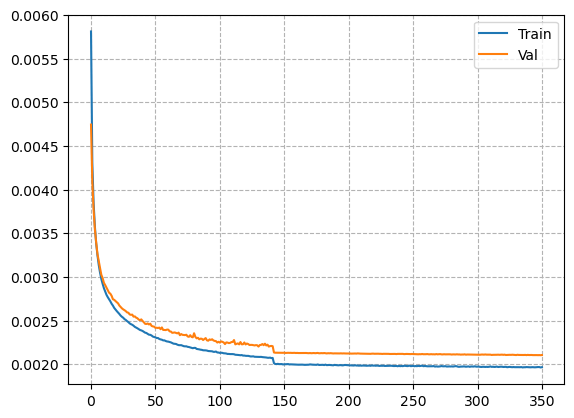

Epoch 351
Trn: 0.00196480	Val: 0.00210386

Epoch 352
Trn: 0.00196469	Val: 0.00210413

Epoch 353
Trn: 0.00196331	Val: 0.00210208

Epoch 354
Trn: 0.00196442	Val: 0.00210436

Epoch 355
Trn: 0.00196344	Val: 0.00210323

Epoch 356
Trn: 0.00196250	Val: 0.00210162

Epoch 357
Trn: 0.00196291	Val: 0.00210251

Epoch 358
Trn: 0.00196280	Val: 0.00210188

Epoch 359
Trn: 0.00196442	Val: 0.00210226

Epoch 360
Trn: 0.00196174	Val: 0.00210221

Saved checkpoint at: checkpoints/chkpnt_20231018_093110_epoch360.pt
Epoch 361
Trn: 0.00196184	Val: 0.00210256

Epoch 362
Trn: 0.00196167	Val: 0.00210289

Epoch 363
Trn: 0.00196403	Val: 0.00210160

Epoch 364
Trn: 0.00196250	Val: 0.00210525

Epoch 365
Trn: 0.00196219	Val: 0.00210292

Epoch 366
Trn: 0.00196411	Val: 0.00210293

Epoch 00368: reducing learning rate of group 0 to 1.0000e-05.
Epoch 367
Trn: 0.00196017	Val: 0.00210402

Epoch 368
Trn: 0.00195426	Val: 0.00209488

Epoch 369
Trn: 0.00195218	Val: 0.00209454

Epoch 370
Trn: 0.00194890	Val: 0.00209435

Saved chec

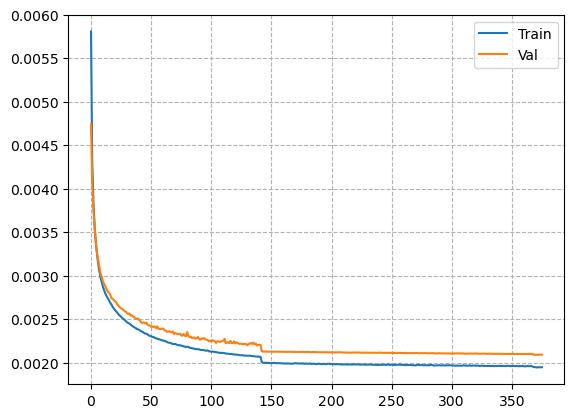

Epoch 376
Trn: 0.00194910	Val: 0.00209448

Epoch 377
Trn: 0.00194954	Val: 0.00209450

Epoch 378
Trn: 0.00195216	Val: 0.00209419

Epoch 379
Trn: 0.00194994	Val: 0.00209455

Epoch 380
Trn: 0.00195265	Val: 0.00209441

Epoch 381
Trn: 0.00195241	Val: 0.00209406

Epoch 382
Trn: 0.00195055	Val: 0.00209434

Epoch 383
Trn: 0.00195027	Val: 0.00209423

Epoch 384
Trn: 0.00195076	Val: 0.00209436

Epoch 385
Trn: 0.00195016	Val: 0.00209444

Epoch 386
Trn: 0.00195351	Val: 0.00209414

Epoch 387
Trn: 0.00194943	Val: 0.00209422

Epoch 388
Trn: 0.00195061	Val: 0.00209428

Epoch 00390: reducing learning rate of group 0 to 1.0000e-06.
Epoch 389
Trn: 0.00194774	Val: 0.00209434

Epoch 390
Trn: 0.00194976	Val: 0.00209373

Saved checkpoint at: checkpoints/chkpnt_20231018_093154_epoch390.pt
Epoch 391
Trn: 0.00195132	Val: 0.00209372

Epoch 392
Trn: 0.00195094	Val: 0.00209366

Epoch 393
Trn: 0.00194980	Val: 0.00209364

Epoch 394
Trn: 0.00194778	Val: 0.00209365

Epoch 395
Trn: 0.00195008	Val: 0.00209368

Epoch 396


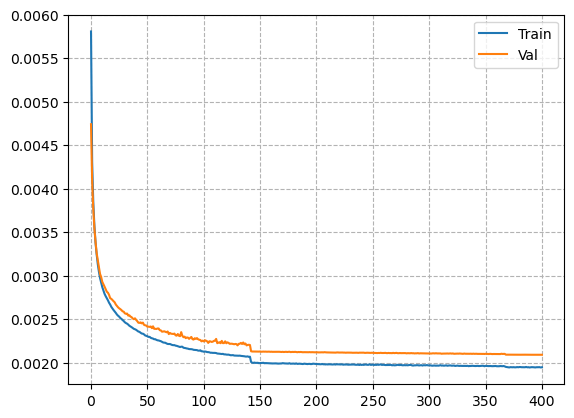

Saved checkpoint at: checkpoints/chkpnt_20231018_093209_epoch400.pt
Epoch 00402: reducing learning rate of group 0 to 1.0000e-07.
Epoch 401
Trn: 0.00194952	Val: 0.00209365

Epoch 402
Trn: 0.00194873	Val: 0.00209365

Epoch 403
Trn: 0.00194837	Val: 0.00209364

Epoch 404
Trn: 0.00194858	Val: 0.00209364

Epoch 405
Trn: 0.00194842	Val: 0.00209363

Epoch 406
Trn: 0.00194882	Val: 0.00209363

Epoch 407
Trn: 0.00194836	Val: 0.00209363

Epoch 408
Trn: 0.00194981	Val: 0.00209363

Epoch 409
Trn: 0.00194894	Val: 0.00209363

Epoch 410
Trn: 0.00194681	Val: 0.00209363

Saved checkpoint at: checkpoints/chkpnt_20231018_093225_epoch410.pt
Epoch 411
Trn: 0.00194589	Val: 0.00209363

Epoch 00413: reducing learning rate of group 0 to 1.0000e-08.
Epoch 412
Trn: 0.00194849	Val: 0.00209363

Epoch 413
Trn: 0.00194851	Val: 0.00209363

Epoch 414
Trn: 0.00194888	Val: 0.00209363

Epoch 415
Trn: 0.00194709	Val: 0.00209363

Epoch 416
Trn: 0.00195209	Val: 0.00209363

Epoch 417
Trn: 0.00194853	Val: 0.00209363

Epoch 418

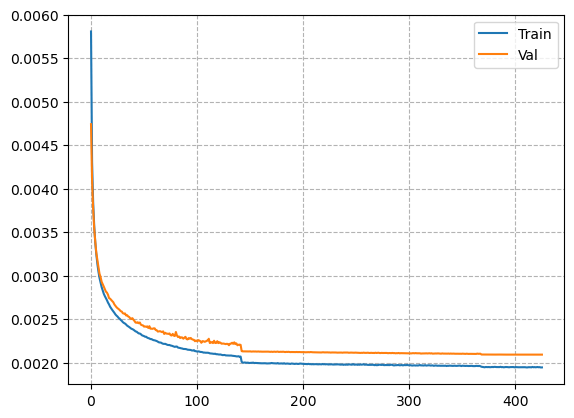

Epoch 426
Trn: 0.00195129	Val: 0.00209363

Epoch 427
Trn: 0.00194879	Val: 0.00209363

Epoch 428
Trn: 0.00194915	Val: 0.00209363

Epoch 429
Trn: 0.00194855	Val: 0.00209363

Epoch 430
Trn: 0.00194590	Val: 0.00209363

Saved checkpoint at: checkpoints/chkpnt_20231018_093255_epoch430.pt
Epoch 431
Trn: 0.00194958	Val: 0.00209363

Epoch 432
Trn: 0.00194897	Val: 0.00209363

Epoch 433
Trn: 0.00195206	Val: 0.00209363

Epoch 434
Trn: 0.00195015	Val: 0.00209363

Epoch 435
Trn: 0.00195185	Val: 0.00209363

Epoch 436
Trn: 0.00194972	Val: 0.00209363

Epoch 437
Trn: 0.00194800	Val: 0.00209363

Epoch 438
Trn: 0.00195001	Val: 0.00209363

Epoch 439
Trn: 0.00194847	Val: 0.00209363

Epoch 440
Trn: 0.00194722	Val: 0.00209363

Saved checkpoint at: checkpoints/chkpnt_20231018_093309_epoch440.pt
Epoch 441
Trn: 0.00194824	Val: 0.00209363

Epoch 442
Trn: 0.00194921	Val: 0.00209363

Epoch 443
Trn: 0.00194715	Val: 0.00209363

Epoch 444
Trn: 0.00194581	Val: 0.00209363

Epoch 445
Trn: 0.00194850	Val: 0.00209363

Epoc

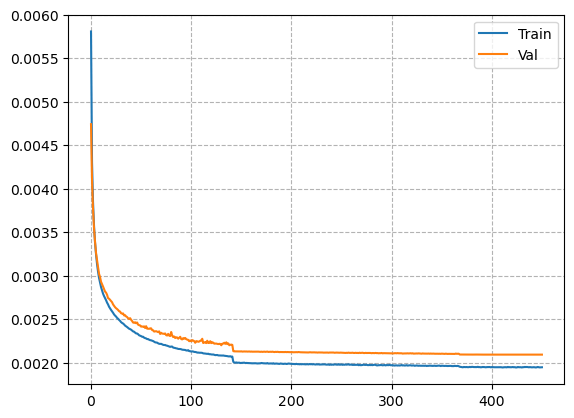

Saved checkpoint at: checkpoints/chkpnt_20231018_093325_epoch450.pt
Epoch 451
Trn: 0.00194730	Val: 0.00209363

Epoch 452
Trn: 0.00194780	Val: 0.00209363

Epoch 453
Trn: 0.00194840	Val: 0.00209363

Epoch 454
Trn: 0.00195042	Val: 0.00209363

Epoch 455
Trn: 0.00194877	Val: 0.00209363

Epoch 456
Trn: 0.00195061	Val: 0.00209363

Epoch 457
Trn: 0.00195036	Val: 0.00209363

Epoch 458
Trn: 0.00194916	Val: 0.00209363

Epoch 459
Trn: 0.00194993	Val: 0.00209363

Epoch 460
Trn: 0.00194835	Val: 0.00209363

Saved checkpoint at: checkpoints/chkpnt_20231018_093339_epoch460.pt
Epoch 461
Trn: 0.00194907	Val: 0.00209363

Epoch 462
Trn: 0.00194885	Val: 0.00209363

Epoch 463
Trn: 0.00194745	Val: 0.00209363

Epoch 464
Trn: 0.00194911	Val: 0.00209363

Epoch 465
Trn: 0.00194817	Val: 0.00209363

Epoch 466
Trn: 0.00194928	Val: 0.00209363

Epoch 467
Trn: 0.00195259	Val: 0.00209363

Epoch 468
Trn: 0.00194659	Val: 0.00209363

Epoch 469
Trn: 0.00195140	Val: 0.00209363

Epoch 470
Trn: 0.00194645	Val: 0.00209363

Save

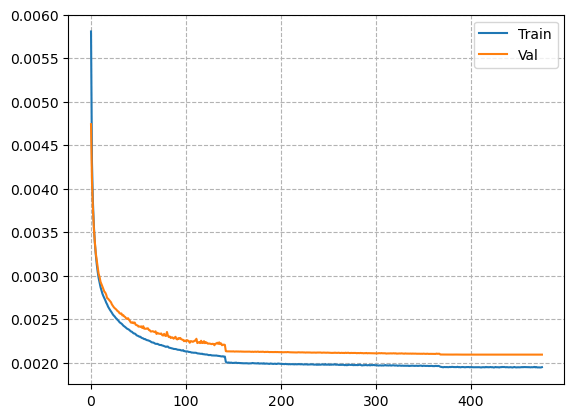

Epoch 476
Trn: 0.00195127	Val: 0.00209363

Epoch 477
Trn: 0.00194915	Val: 0.00209363

Epoch 478
Trn: 0.00195185	Val: 0.00209363

Epoch 479
Trn: 0.00194705	Val: 0.00209363

Epoch 480
Trn: 0.00194992	Val: 0.00209363

Saved checkpoint at: checkpoints/chkpnt_20231018_093409_epoch480.pt
Epoch 481
Trn: 0.00194972	Val: 0.00209363

Epoch 482
Trn: 0.00195006	Val: 0.00209363

Epoch 483
Trn: 0.00194726	Val: 0.00209363

Epoch 484
Trn: 0.00195093	Val: 0.00209363

Epoch 485
Trn: 0.00194721	Val: 0.00209363

Epoch 486
Trn: 0.00194871	Val: 0.00209363

Epoch 487
Trn: 0.00194772	Val: 0.00209363

Epoch 488
Trn: 0.00195165	Val: 0.00209363

Epoch 489
Trn: 0.00194974	Val: 0.00209363

Epoch 490
Trn: 0.00194926	Val: 0.00209363

Saved checkpoint at: checkpoints/chkpnt_20231018_093424_epoch490.pt
Epoch 491
Trn: 0.00194800	Val: 0.00209363

Epoch 492
Trn: 0.00194768	Val: 0.00209363

Epoch 493
Trn: 0.00194649	Val: 0.00209363

Epoch 494
Trn: 0.00194930	Val: 0.00209363

Epoch 495
Trn: 0.00194743	Val: 0.00209363

Epoc

In [150]:
# Training.
n_epochs = 500
lr = 1e-3

checkpoint_dir = 'checkpoints/'
save_interval_epochs = 10
plot_interval_epochs = 25

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

best_loss = np.inf
train_loss = []
val_loss = []
for i in range(n_epochs):
    epoch_train_loss = train_one_epoch(model, train_loader, optimizer, device, model_type)
    epoch_val_loss = validate(model, val_loader, device, model_type)
    scheduler.step(epoch_val_loss)

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)

    print(f"Epoch {i}")
    print_loss_metrics(epoch_train_loss, epoch_val_loss)

    if i % plot_interval_epochs == 0:
        plt.plot(train_loss, label="Train")
        plt.plot(val_loss, label="Val")
        plt.grid(True, which="both", ls="--", c='0.7')
        plt.legend()
        plt.show()


    if i % save_interval_epochs != 0:
        continue

    if epoch_val_loss < best_loss:
        fname = f"chkpnt_{get_date_and_time()}_epoch{i}.pt"
        fpath = os.path.join(checkpoint_dir, fname)

        save_checkpoint(model, optimizer, fpath)

        print("=" * 80)
        print(f"Saved checkpoint at: {fpath}")
        print("=" * 80)

        best_loss = epoch_val_loss

In [88]:
fpath = 'checkpoints/chkpnt_20231018_063837_epoch490.pt'
load_checkpoint(fpath, model, optimizer)
model.eval()

restore = dataset.get_restorer()

# Sample first 16 patches and their reconstructions.
patches = []
with torch.no_grad():
    for i, x in enumerate(dataset):
        x = x.to(device)

        if model_type == 'vae':
            y, mu, log_var = model(x)
        elif model_type == 'ae':
            y, z = model(x)

        x = x.to('cpu')
        y = y.to('cpu')

        x = restore(x)
        y = restore(y)

        x['VOICE NAME'] = f"x{i}"
        y['VOICE NAME'] = f"y{i}"

        patches.append(x)
        patches.append(y)

        if i >= 15:
            break

In [10]:
from chatgpt_util_imports import make_cartridge

fpath = "data/test.syx"

cartridge_data = make_cartridge(patches)
with open(fpath, 'wb') as file:
    file.write(cartridge_data)

In [89]:
fpath = 'checkpoints/chkpnt_20231018_063837_epoch490.pt'
load_checkpoint(fpath, model, optimizer)

embeddings = collect_embeddings(model, dataset, device, model_type)

In [135]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
result = pca.fit_transform(embeddings)

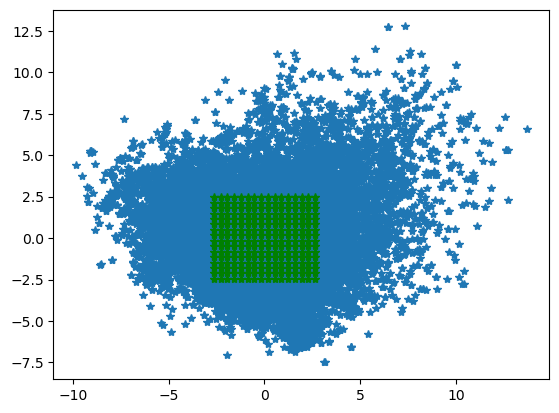

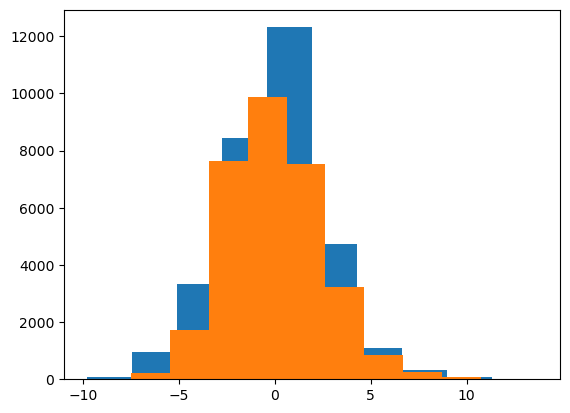

In [137]:
means = np.mean(result, axis=0)
stds = np.std(result, axis=0)

mins = means - stds
maxs = means + stds

n_steps = 16

grid = np.empty((n_steps, n_components))

for i in range(n_components):
    grid[:, i] = np.linspace(mins[i], maxs[i], n_steps)

plt.plot(result[:, 0], result[:, 1], '*')
for i in range(n_steps):
    plt.plot(grid[:, 0], grid[i, 1].repeat(n_steps), '*g')
plt.show()

plt.hist(result[:, 0])
plt.hist(result[:, 1])
plt.show()

In [138]:
grid_embeddings = np.empty((n_steps, n_steps, n_latent))

for i in range(n_steps):
    for j in range(n_steps):
        z = pca.inverse_transform((grid[i, 0], grid[j, 1]))
        grid_embeddings[i, j, :] = z

In [143]:
patches = []
middle_idx = n_steps // 2 - 1

with torch.no_grad():
    for i in range(n_steps):
        z = grid_embeddings[i, middle_idx, :]
        z = torch.Tensor(z).to(device)

        x = model.decode(z).cpu()
        x = restore(x)

        x['VOICE NAME'] = f"{i}, {middle_idx}"

        patches.append(x)
    for i in range(n_steps):
        z = grid_embeddings[middle_idx, i, :]
        z = torch.Tensor(z).to(device)

        x = model.decode(z).cpu()
        x = restore(x)

        x['VOICE NAME'] = f"{middle_idx}, {i}"
        patches.append(x)

In [144]:
fpath = "data/pca_grid.syx"

cartridge_data = make_cartridge(patches)
with open(fpath, 'wb') as file:
    file.write(cartridge_data)